In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

#logistic regression
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

#model assessment
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

In [8]:
#Planning to use logistic regression, KNN, Random Forest


In [9]:
waze_cleaned = pd.read_csv("../data/waze_processed.csv")
waze_cleaned.head()

,Android,iPhone,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
0,1,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19
1,0,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11
2,1,0,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8
3,0,1,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3
4,1,0,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18


<h3> Classes are inherently imbalanced

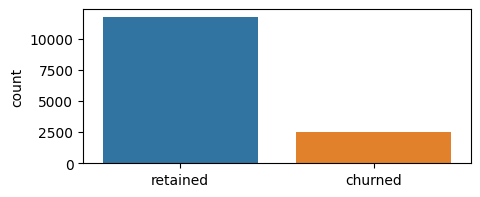

In [10]:
plt.figure(figsize = (5,2))
sns.countplot(x = waze_cleaned["label"])
plt.xlabel("");

In [11]:
retained_count = waze_cleaned['label'].value_counts().get("retained", 0)
churn_count = waze_cleaned['label'].value_counts().get("churned", 0)
churn_rate = churn_count/(churn_count+retained_count)
print("Total retained count:", retained_count)
print("Total churn count:", churn_count)
print("Churn rate", round(churn_rate, 2))

Total retained count: 11763
Total churn count: 2536
Churn rate 0.18


In [12]:
#The above cells show that the data is unbalanced. 
#Successful modlling may necessitate resampling to balance classes. 

<h3> Split data into testing and training datasets

In [13]:
X = waze_cleaned.drop('label', axis = 1)
y = waze_cleaned['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)
# Standardize the magnitude of numeric features using a scaler
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

(a) Define X and y

(b) Perform train/test split on (X, y)

(c) Create an object of the class associated with the algorithm to be used--in this case LogisticRegression

(d) Build an actual model using thefit method from the class associated with the algorithm to be used (using the training set)

(e) Predict with the built model using thepredict method from the class (training set and test set)

(f) Compute performance metrics (in this case, accuracy) for the training and test predictions. The metrics to be used and their interpretation will depend on the application at hand

(g) Determine if the model can be improved--repeat as needed with additional algorithms and/or by applying hyper-parameter tuning

(h) Compare and Combine all best models as needed

<h2> Logistic Regression 

In [14]:
#Instantiate the model and set parameters
#I also tried the newton_cg solver, but went with liblinear and l1 regularization. Similar accuracy results
clf = LogisticRegression(solver = 'liblinear', max_iter = 500)

In [15]:
#Fit the model using training set
clf.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=500, solver='liblinear')

In [16]:
#Predict y test and check accuracy on predicting test set
y_predict = clf.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_predict)
test_accuracy

0.8244755244755245

In [17]:
#check accuracy of model on training set to check for over/underfitting
y_train_predicted = clf.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, y_train_predicted)
train_accuracy

0.8255966430632048

#While checking for accuracy is only the first step, the well matched train/test accuracy (low variance, with only slightly higher accuracy for training set) is a good start with no obvious over/underfitting. 

In [18]:
cm = confusion_matrix(y_test, y_predict, labels = clf.classes_)
cm

array([[  34,  463],
       [  39, 2324]])

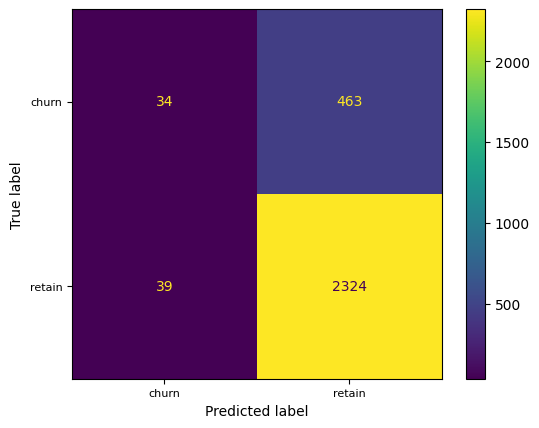

In [19]:

_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm 
                                    , display_labels = ['churn', 'retain'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
#double check labels, could be mixed up?
ax.set_xticklabels(labels = ['churn', 'retain'], fontsize = 8)
ax.set_yticklabels(labels = ['churn', 'retain'], fontsize = 8)
display_cm.plot(ax = ax);

In [20]:
#above results use C=1.00 (default)
#now use grid search to tune hyperparameter C value


In [21]:
Cs = [0.001, 0.01, 0.1, 1, 10, 100]

table = pd.DataFrame(columns = ['C','Accuracy'])
table['C'] = Cs


j = 0
for C in Cs:
    
    # Apply logistic regression model to training data
    Logreg = LogisticRegression( C = C,)
    Logreg.fit(X_train_scaled, y_train)
    
    # Predict using model
    y_pred_lr = Logreg.predict(X_test_scaled)
    
    # Saving accuracy score in table
    table.iloc[j,1] = accuracy_score(y_test,y_pred_lr)
    j += 1
    
table   

,C,Accuracy
0,0.001,0.825524
1,0.010,0.823776
2,0.100,0.824825
3,1.000,0.824476
4,10.000,0.824476
5,100.000,0.824476


In [22]:
#These results show that there is a better C value than the default C=1 according to accuracy
#Let's find try out a confusion matrix for the best C (C = .001)

In [23]:
#instantiate new model with C = .001
clf = LogisticRegression(solver = 'liblinear', max_iter = 500, C = .001)

In [24]:
#Fit the model using training set
clf.fit(X_train_scaled, y_train)

LogisticRegression(C=0.001, max_iter=500, solver='liblinear')

In [25]:
#Predict y test and check accuracy on predicting test set
y_predict = clf.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_predict)
test_accuracy
#check accuracy of model on training set to check for over/underfitting
y_train_predicted = clf.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, y_train_predicted)
train_accuracy
print("train accuracy:", train_accuracy)
print("test accuracy:", test_accuracy)


train accuracy: 0.8236733980243028
test accuracy: 0.8237762237762237


<h4> As expected, accuracies were slightly better using the new C values. Lets see the new confusion matrix

In [26]:
cm = confusion_matrix(y_test, y_predict, labels = clf.classes_)
cm

array([[  16,  481],
       [  23, 2340]])

<h4> This shows significantly worse results. This model, while slightly improved in correctly predicting retention, correctly predicted only about half of the true churn, the target of this analysis. This is a good example of why we don't rely solely on accuracy for model testing.  

<h2> K Nearest Neighbors 

<h2> Random Forest

In [27]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=0.823
Random Forest: f1-score=0.773


In [28]:
cm = confusion_matrix(y_test, y_pred, labels = clf.classes_)
cm

array([[  50,  447],
       [  59, 2304]])

12


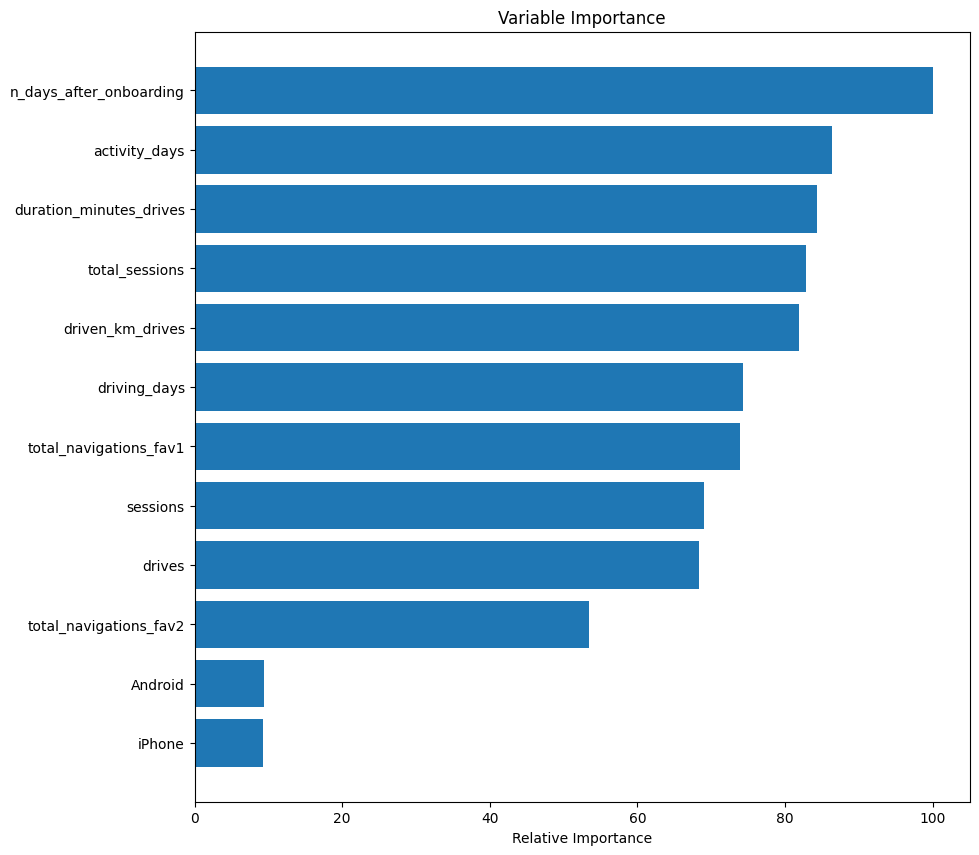

In [29]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()